# RTMA Daily Precipitation Visualization

## Overview
This Python script downloads Real-Time Mesoscale Analysis (RTMA) precipitation data for a specified date and creates a high-quality visualization that combines precipitation data with underlying terrain from Digital Elevation Model (DEM) data. The visualization includes contour lines, city labels, and various map features.

## Dependencies
- **matplotlib**: For creating visualizations
- **cartopy**: For map projections and geographical features
- **herbie**: For downloading RTMA data
- **numpy**: For numerical operations
- **xarray**: For working with labeled multi-dimensional arrays
- **rasterio**: For reading DEM data (not imported directly in the main code)
- **os, time, warnings**: Standard Python libraries for various utilities
- **datetime**: For date and time operations

## Main Functions

### `load_dem(dem_file, lon_min, lon_max, lat_min, lat_max, timeout=60)`
Loads Digital Elevation Model (DEM) data for the specified region.

**Parameters:**
- `dem_file`: Path to the DEM file
- `lon_min`, `lon_max`, `lat_min`, `lat_max`: Geographic boundaries
- `timeout`: Maximum time in seconds to spend loading the DEM

**Returns:**
- `dem`: The elevation data array
- `lon`, `lat`: Longitude and latitude arrays

### `create_hillshade(dem, azimuth=315, altitude=45, timeout=30)`
Creates a hillshade array from a DEM for 3D terrain effect.

**Parameters:**
- `dem`: Elevation data array
- `azimuth`: Light source direction in degrees (default: 315)
- `altitude`: Light source altitude in degrees (default: 45)
- `timeout`: Maximum processing time in seconds

**Returns:**
- Hillshade array or None if an error occurs

### `download_and_process_rtma(date_str, bbox)`
Downloads and processes RTMA precipitation data for all hours in a day.

**Parameters:**
- `date_str`: Date string in YYYY-MM-DD format
- `bbox`: Bounding box as (lat_min, lon_min, lat_max, lon_max)

**Returns:**
- `accumulated_precip`: Accumulated precipitation data
- `coord_names`: Tuple of coordinate names (lat_coord, lon_coord)
- `successful_hours`: List of hours successfully processed

### `create_visualization(date_str, accumulated_precip, coord_names, successful_hours, dem_file, output_dir, bbox, unique_filename=None)`
Creates the final visualization combining precipitation and terrain.

**Parameters:**
- `date_str`: Date string in YYYY-MM-DD format
- `accumulated_precip`: Accumulated precipitation data
- `coord_names`: Tuple of coordinate names (lat_coord, lon_coord)
- `successful_hours`: List of hours successfully processed
- `dem_file`: Path to the DEM file
- `output_dir`: Directory to save the output
- `bbox`: Bounding box as (lat_min, lon_min, lat_max, lon_max)
- `unique_filename`: Optional unique filename for the output

**Returns:**
- `success`: Boolean indicating success or failure
- `fig`: The matplotlib figure object
- `output_file`: Path to the saved output file

## Workflow
1. The script prompts for a date input in YYYY-MM-DD format
2. Configuration parameters are set:
   - `output_dir`: Directory for output files
   - `dem_file`: Path to DEM data file
   - `bbox`: Geographic boundaries (lat_min, lon_min, lat_max, lon_max)
3. A unique filename is generated using the current timestamp
4. RTMA precipitation data is downloaded and processed for each hour of the specified day
5. A visualization is created combining:
   - Terrain visualization using DEM data with hillshade effect
   - Accumulated precipitation data with a blue colormap
   - Contour lines for precipitation amounts
   - City labels for major cities in the region
   - Map features (state boundaries, lakes, rivers)
   - Gridlines and colorbar
6. The visualization is saved as a high-resolution PNG image
7. A precipitation summary is printed showing maximum precipitation and area coverage

## Usage Example
```python
# Run the script
# When prompted, enter a date in YYYY-MM-DD format
Enter date (YYYY-MM-DD): 2023-04-15
```

## Output
- A PNG image with the visualization is saved to the specified output directory
- Console output includes:
  - Progress information during downloading and processing
  - Errors encountered during processing
  - Summary of precipitation statistics

## Customization
- **Geographic Region**: Modify the `bbox` parameter to change the region of interest
- **DEM File**: Update the `dem_file` path to use different terrain data
- **Output Directory**: Change the `output_dir` parameter to save outputs elsewhere
- **City Labels**: Edit the `cities` dictionary to show different cities
- **Styling**: Adjust matplotlib parameters in the script preamble

## Error Handling
The script includes comprehensive error handling:
- Timeout protection for DEM loading and hillshade creation
- Error catching for missing data
- Grid compatibility checks
- Fallbacks for missing terrain data
- Detailed error messages for troubleshooting

## Technical Details
- The script uses the Herbie package to access RTMA data from NOAA
- Precipitation is accumulated across all hours of the specified day
- The visualization uses Cartopy for mapping features and projections
- DEM data is used to create both terrain coloring and hillshade effects
- A custom blue colormap is created for precipitation visualization

Starting RTMA precipitation visualization for 2025-01-31
Region: 39.5°N to 41.0°N, -113.0°E to -109.0°E
Output will be saved as: rtma_daily_precip_2025-01-31_20250322_204300.png

Processing hour 00:00 UTC...
✅ Found ┊ model=rtma ┊ product=pcp ┊ 2025-Jan-31 00:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
  Found precipitation data: tp
  Converting longitude from 0-360 to -180-180
  Successfully added precipitation for 00:00 UTC

Processing hour 01:00 UTC...
✅ Found ┊ model=rtma ┊ product=pcp ┊ 2025-Jan-31 01:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
  Found precipitation data: tp
  Converting longitude from 0-360 to -180-180
  Successfully added precipitation for 01:00 UTC

Processing hour 02:00 UTC...
✅ Found ┊ model=rtma ┊ product=pcp ┊ 2025-Jan-31 02:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
  Found precipitation data: tp
  Converting longitude from 0-360 to -180-180
  Successfully added precipitation for 02:00 UTC

Processing hour 03:00 UTC...
✅ Found ┊ model=rtma ┊ product=pcp ┊ 2025-Jan-31 03

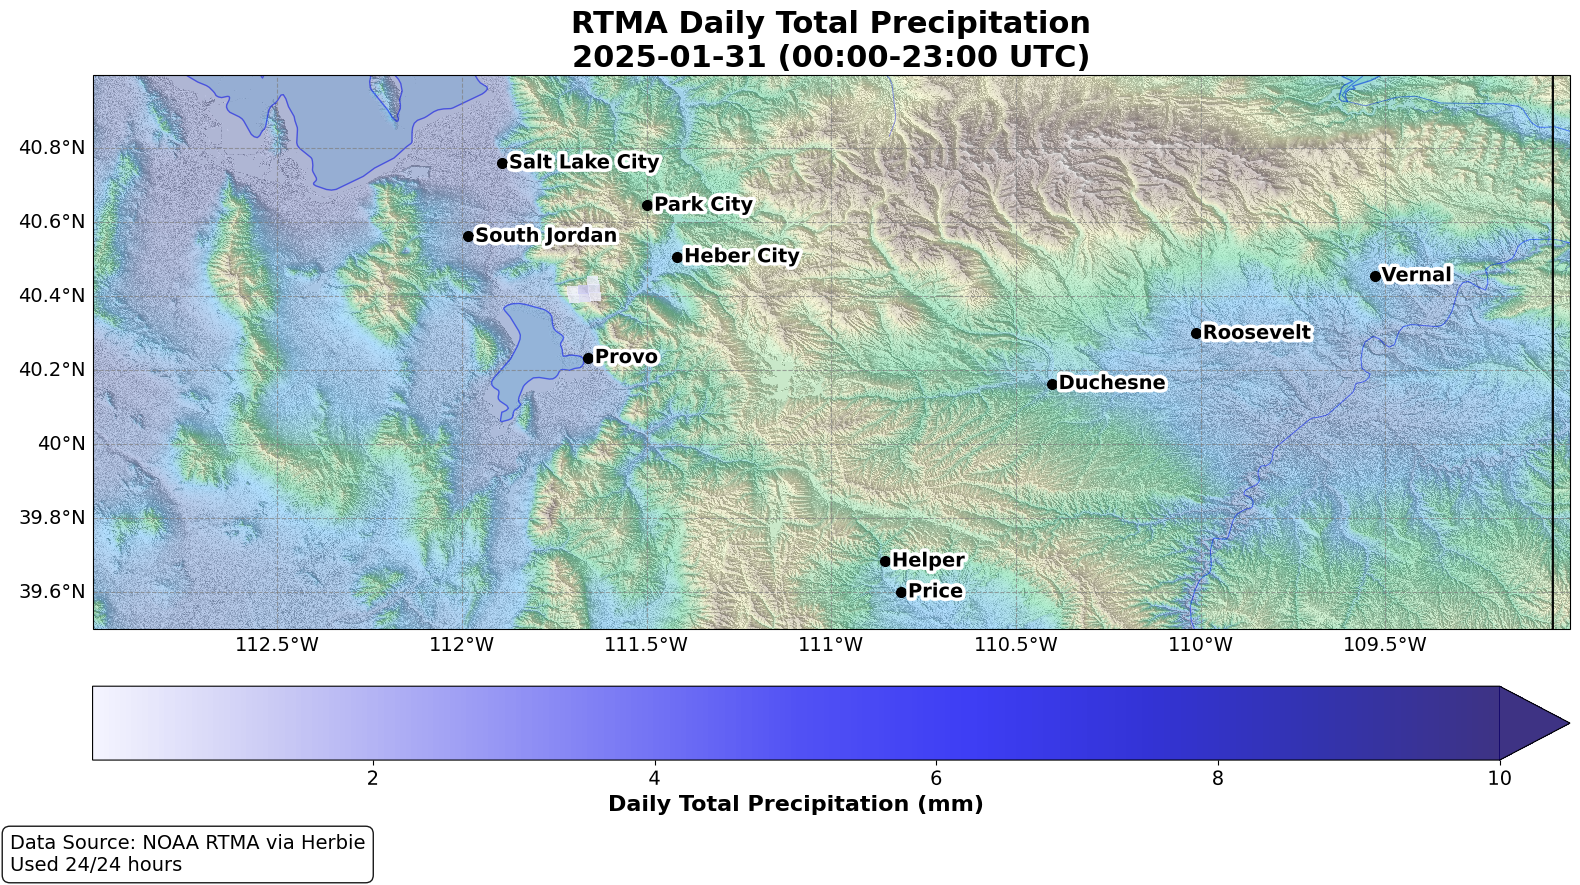

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import numpy as np
import os
import time
import xarray as xr
from datetime import datetime, timedelta
import warnings
import matplotlib.patheffects as patheffects
from matplotlib.colors import LinearSegmentedColormap

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot styling
plt.style.use('default')
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.titlesize': 24
})

def load_dem(dem_file, lon_min, lon_max, lat_min, lat_max, timeout=60):
    """Load Digital Elevation Model (DEM) data with timeout protection."""
    start_time = time.time()

    try:
        import rasterio

        print(f"Loading DEM data from: {dem_file}")

        if not os.path.exists(dem_file):
            print(f"ERROR: DEM file not found: {dem_file}")
            return None, None, None

        with rasterio.open(dem_file) as src:
            print(f"DEM file opened. Shape: {src.shape}")

            # Read the entire dataset
            dem = src.read(1)

            # Check timeout
            if time.time() - start_time > timeout:
                print("DEM loading is taking too long, aborting")
                return None, None, None

            # Get transform to convert pixel coordinates to geographic coordinates
            transform = src.transform

            # Calculate longitude and latitude arrays
            height, width = dem.shape
            lon = np.linspace(transform.c, transform.c + width * transform.a, width)
            lat = np.linspace(transform.f, transform.f + height * transform.e, height)

            # Convert longitudes if necessary (0-360 to -180-180)
            if lon.min() > 180:
                lon = (lon + 180) % 360 - 180

            print(f"DEM loaded successfully. Elevation range: {np.nanmin(dem):.1f}m to {np.nanmax(dem):.1f}m")
            return dem, lon, lat

    except ImportError:
        print("Required libraries for DEM processing not available")
    except Exception as e:
        print(f"Error loading DEM: {e}")

    return None, None, None

def create_hillshade(dem, azimuth=315, altitude=45, timeout=30):
    """Create a hillshade array from a DEM array for 3D terrain effect."""
    if dem is None:
        return None

    start_time = time.time()

    try:
        dem_copy = dem.copy()

        # Fill NaN values to avoid artifacts
        if np.any(np.isnan(dem_copy)):
            mask = np.isnan(dem_copy)
            dem_copy[mask] = np.nanmean(dem_copy)

        # Convert angles to radians
        azimuth = 360.0 - azimuth
        azimuth_rad = azimuth * np.pi / 180.0
        altitude_rad = altitude * np.pi / 180.0

        # Check timeout
        if time.time() - start_time > timeout:
            print("Hillshade processing is taking too long, aborting")
            return None

        # Calculate slope and aspect
        x, y = np.gradient(dem_copy)
        slope = np.pi/2 - np.arctan(np.sqrt(x*x + y*y))
        aspect = np.arctan2(-x, y)

        # Calculate hillshade
        hillshade = np.sin(altitude_rad) * np.sin(slope) + \
                  np.cos(altitude_rad) * np.cos(slope) * \
                  np.cos(azimuth_rad - aspect)

        # Scale to 0-1
        hillshade = (hillshade + 1) / 2

        return hillshade

    except Exception as e:
        print(f"Error creating hillshade: {e}")
        return None

def download_and_process_rtma(date_str, bbox):
    """Download and process RTMA precipitation data for all hours in a day."""
    # Parse the date
    try:
        base_date = datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError:
        print(f"Error: Invalid date format: {date_str}. Use YYYY-MM-DD.")
        return None, None, []

    # Extract bounding box coordinates
    lat_min, lon_min, lat_max, lon_max = bbox

    print(f"Downloading RTMA precipitation data for {date_str}...")

    # Initialize variables
    accumulated_precip = None
    successful_hours = []
    failed_hours = []
    lat_coord = None
    lon_coord = None

    # Process each hour
    for hour in range(24):
        hour_time = base_date + timedelta(hours=hour)
        time_str = hour_time.strftime("%Y-%m-%d %H:%M")

        print(f"\nProcessing hour {hour:02d}:00 UTC...")

        try:
            # Initialize Herbie for this hour
            H = Herbie(time_str, model="rtma", product="pcp", fxx=0)

            # Download data
            file_path = H.download()
            if not os.path.exists(file_path):
                print(f"  Failed to download data for {hour:02d}:00 UTC")
                failed_hours.append(hour)
                continue

            # Check for precipitation data in inventory
            inventory = H.inventory()
            has_precip = any(row['variable'] == 'APCP' for idx, row in inventory.iterrows())

            if not has_precip:
                print(f"  No precipitation data found for {hour:02d}:00 UTC")
                failed_hours.append(hour)
                continue

            # Extract data using xarray
            precip_result = H.xarray()

            # Find precipitation variable and dataset
            precip_ds = None
            precip_var = None

            if isinstance(precip_result, list):
                for ds in precip_result:
                    for var in ds.data_vars:
                        if var in ['tp', 'APCP']:
                            precip_ds = ds
                            precip_var = var
                            break
            else:
                precip_ds = precip_result
                if precip_ds and len(precip_ds.data_vars) > 0:
                    for var in precip_ds.data_vars:
                        if var in ['tp', 'APCP']:
                            precip_var = var
                            break

                    # Use first variable if no specific precipitation variable found
                    if precip_var is None and len(precip_ds.data_vars) > 0:
                        precip_var = list(precip_ds.data_vars)[0]

            # Check if we found data
            if precip_ds is None or precip_var is None:
                print(f"  Failed to extract precipitation data for {hour:02d}:00 UTC")
                failed_hours.append(hour)
                continue

            print(f"  Found precipitation data: {precip_var}")

            # Identify coordinate names
            if lat_coord is None or lon_coord is None:
                if 'latitude' in precip_ds.coords and 'longitude' in precip_ds.coords:
                    lat_coord, lon_coord = 'latitude', 'longitude'
                elif 'lat' in precip_ds.coords and 'lon' in precip_ds.coords:
                    lat_coord, lon_coord = 'lat', 'lon'
                else:
                    print(f"  Could not identify coordinate names. Available: {list(precip_ds.coords)}")
                    failed_hours.append(hour)
                    continue

            # Convert longitudes if needed
            if precip_ds[lon_coord].min() > 180:
                print("  Converting longitude from 0-360 to -180-180")
                precip_ds = precip_ds.assign_coords({lon_coord: (((precip_ds[lon_coord] + 180) % 360) - 180)})

            # Extract region of interest
            if precip_ds[lat_coord].ndim == 1 and precip_ds[lon_coord].ndim == 1:
                # 1D coordinates
                precip_region = precip_ds.sel({
                    lat_coord: slice(lat_max, lat_min),
                    lon_coord: slice(lon_min, lon_max)
                })
            else:
                # 2D coordinates
                lat_mask = (precip_ds[lat_coord] >= lat_min) & (precip_ds[lat_coord] <= lat_max)
                lon_mask = (precip_ds[lon_coord] >= lon_min) & (precip_ds[lon_coord] <= lon_max)
                combined_mask = lat_mask & lon_mask

                y_indices, x_indices = np.where(combined_mask)
                if len(y_indices) > 0 and len(x_indices) > 0:
                    y_min, y_max = y_indices.min(), y_indices.max()
                    x_min, x_max = x_indices.min(), x_indices.max()
                    precip_region = precip_ds.isel(y=slice(y_min, y_max+1), x=slice(x_min, x_max+1))
                else:
                    print("  No data points in the region of interest")
                    failed_hours.append(hour)
                    continue

            # Replace NaN with 0.0 for accumulation
            precip_data = precip_region[precip_var].fillna(0.0)

            # Add to accumulated precipitation
            if accumulated_precip is None:
                accumulated_precip = precip_data.copy()
            else:
                # Check if grids are compatible
                if (accumulated_precip.shape == precip_data.shape and
                    np.all(accumulated_precip[lon_coord] == precip_data[lon_coord]) and
                    np.all(accumulated_precip[lat_coord] == precip_data[lat_coord])):
                    accumulated_precip = accumulated_precip + precip_data
                else:
                    print(f"  Grid mismatch: Accumulated shape {accumulated_precip.shape}, current shape {precip_data.shape}")
                    failed_hours.append(hour)
                    continue

            successful_hours.append(hour)
            print(f"  Successfully added precipitation for {hour:02d}:00 UTC")

        except Exception as e:
            print(f"  Error processing hour {hour:02d}:00 UTC: {e}")
            failed_hours.append(hour)

    # Check if we accumulated any data
    if accumulated_precip is None:
        print("Failed to accumulate any precipitation data")
        return None, None, []

    print(f"\nSuccessfully processed {len(successful_hours)} out of 24 hours")
    if failed_hours:
        print(f"Failed hours: {', '.join(f'{h:02d}' for h in failed_hours)}")

    return accumulated_precip, (lat_coord, lon_coord), successful_hours

def create_visualization(date_str, accumulated_precip, coord_names, successful_hours,
                         dem_file, output_dir, bbox, unique_filename=None):
    """Create the final visualization combining precipitation and terrain."""
    # Make sure we have data
    if accumulated_precip is None:
        print("No precipitation data to visualize")
        return False, None, None

    lat_coord, lon_coord = coord_names
    lat_min, lon_min, lat_max, lon_max = bbox

    # Create safe filename
    date_safe = datetime.strptime(date_str, "%Y-%m-%d").strftime("%Y-%m-%d")

    # Use unique filename if provided, otherwise use default
    if unique_filename:
        output_file = os.path.join(output_dir, f"{unique_filename}.png")
    else:
        output_file = os.path.join(output_dir, f"rtma_daily_precip_{date_safe}.png")

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set up the figure and projection
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': projection})

    # Set the map extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

    # Load DEM data first
    print("\nLoading DEM data...")
    dem, dem_lons, dem_lats = load_dem(dem_file, lon_min, lon_max, lat_min, lat_max)

    # Plot terrain if available
    if dem is not None and dem_lons is not None and dem_lats is not None:
        try:
            # Create hillshade
            hillshade = create_hillshade(dem)

            if hillshade is not None:
                # Plot hillshade for 3D effect
                ax.pcolormesh(
                    dem_lons, dem_lats, hillshade,
                    cmap='gray',
                    alpha=0.5,
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )

                # Add colored elevation on top
                ax.pcolormesh(
                    dem_lons, dem_lats, dem,
                    cmap='terrain',
                    alpha=0.3,
                    transform=projection,
                    zorder=2,
                    shading='auto'
                )
                print("Added terrain visualization")
            else:
                # Just plot basic terrain
                ax.pcolormesh(
                    dem_lons, dem_lats, dem,
                    cmap='terrain',
                    alpha=0.4,
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )
        except Exception as e:
            print(f"Error visualizing terrain: {e}")
            # Add basic background
            ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=1, facecolor='#f2f2f2')
    else:
        print("No terrain data available, using basic background")
        ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=1, facecolor='#f2f2f2')

    # Add standard features (replacing shapefile functionality)
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none", alpha=0.8, zorder=7)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.6)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.6)

    # Add gridlines
    try:
        gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.7, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
    except Exception as e:
        print(f"Error adding gridlines: {e}")

    # Define blue colormap for precipitation
    blues = [
        (0.95, 0.95, 1.0),      # Very light blue
        (0.75, 0.75, 0.95),     # Light blue
        (0.55, 0.55, 0.95),     # Medium-light blue
        (0.35, 0.35, 0.95),     # Medium blue
        (0.15, 0.15, 0.95),     # Deep blue
        (0.05, 0.05, 0.95),     # Very deep blue
        (0.0, 0.0, 0.8),        # Navy
        (0.0, 0.0, 0.6),        # Dark navy
        (0.05, 0.0, 0.4)        # Purple-navy
    ]
    precip_cmap = LinearSegmentedColormap.from_list('precip_blues', blues)
    precip_cmap.set_under('white')

    # Set precipitation thresholds
    vmin = 0.01  # mm
    max_val = float(accumulated_precip.max().values) if not np.isnan(accumulated_precip.max().values) else 1.0
    vmax = max(10.0, max_val * 1.1)

    # Create mask for precipitation
    masked_data = accumulated_precip.where(accumulated_precip > vmin)

    # Plot precipitation data
    print("Adding precipitation data...")
    try:
        p = ax.pcolormesh(
            accumulated_precip[lon_coord],
            accumulated_precip[lat_coord],
            masked_data,
            transform=projection,
            cmap=precip_cmap,
            vmin=vmin,
            vmax=vmax,
            alpha=0.8,
            zorder=8
        )
    except Exception as e:
        print(f"Error plotting precipitation: {e}")
        return False, fig, output_file

    # Add contour lines
    try:
        contour_levels = np.linspace(vmin, vmax, 8)
        contours = ax.contour(
            accumulated_precip[lon_coord],
            accumulated_precip[lat_coord],
            masked_data,
            levels=contour_levels,
            colors='black',
            linewidths=0.8,
            alpha=0.7,
            transform=projection,
            zorder=9
        )

        # Add contour labels
        plt.clabel(contours, inline=True, fontsize=10, fmt='%.1f', colors='black')
    except Exception as e:
        print(f"Error adding contours: {e}")

    # Add city labels
    cities = {
        "Salt Lake City": (40.7608, -111.8910),
        "Provo": (40.2338, -111.6585),
        "Park City": (40.6461, -111.4980),
        "South Jordan": (40.5622, -111.9825),
        "Heber City": (40.5068, -111.4168),
        "Duchesne": (40.1635, -110.4029),
        "Roosevelt": (40.2994, -110.0126),
        "Vernal": (40.4555, -109.5287),
        "Price": (39.5994, -110.8107),
        "Helper": (39.6830, -110.8541)
    }

    try:
        for city, (lat, lon) in cities.items():
            if (lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max):
                ax.plot(lon, lat, 'ko', markersize=7, transform=projection, zorder=10)
                ax.text(lon, lat, f" {city}", fontsize=14, transform=projection,
                      verticalalignment='center', fontweight='bold',
                      path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                      zorder=10)
    except Exception as e:
        print(f"Error adding city labels: {e}")

    # Add colorbar
    try:
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, extend='max')
        cbar.set_label("Daily Total Precipitation (mm)", fontsize=16, fontweight='bold')
        cbar.ax.tick_params(labelsize=14)

        # Add white outline to colorbar labels
        for label in cbar.ax.xaxis.get_ticklabels():
            label.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    except Exception as e:
        print(f"Error adding colorbar: {e}")

    # Add title
    try:
        hour_range_text = "(00:00-23:00 UTC)" if len(successful_hours) == 24 else \
                         f"({', '.join(f'{h:02d}:00' for h in sorted(successful_hours))} UTC)"
        ax.set_title(f"RTMA Daily Total Precipitation\n{date_safe} {hour_range_text}",
                   fontsize=22, fontweight='bold')
    except Exception as e:
        print(f"Error adding title: {e}")

    # Add data source info
    try:
        plt.figtext(0.01, 0.01, f"Data Source: NOAA RTMA via Herbie\nUsed {len(successful_hours)}/24 hours",
                  fontsize=14,
                  bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.9))
    except Exception as e:
        print(f"Error adding source info: {e}")

    # Save figure
    try:
        print(f"Saving visualization to {output_file}")
        plt.savefig(output_file, dpi=600, bbox_inches="tight")
    except Exception as e:
        print(f"Error saving figure: {e}")
        return False, fig, output_file

    # Create precipitation summary
    try:
        max_precip = float(masked_data.max().values) if not np.isnan(masked_data.max().values) else 0.0
        nonzero_count = np.sum(~np.isnan(masked_data.values))
        total_count = masked_data.size
        percent_with_precip = (nonzero_count / total_count) * 100 if total_count > 0 else 0

        print("\nPrecipitation Summary:")
        print(f"Maximum daily precipitation: {max_precip:.2f} mm")
        print(f"Area coverage: {percent_with_precip:.1f}% of the region received measurable precipitation")
        print(f"Hours included: {len(successful_hours)}/24")
    except Exception as e:
        print(f"Error creating summary: {e}")

    # For Jupyter notebooks, display the plot inline
    plt.tight_layout()

    return True, fig, output_file

# Simple date input for Jupyter
date_str = input("Enter date (YYYY-MM-DD): ")

# Set configuration
output_dir = "./rtma_analysis"
dem_file = "/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif"
bbox = (39.5, -113.0, 41.0, -109.0)  # (lat_min, lon_min, lat_max, lon_max)

# Generate a unique filename with current timestamp
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
unique_filename = f"rtma_daily_precip_{date_str}_{current_time}"

print(f"Starting RTMA precipitation visualization for {date_str}")
print(f"Region: {bbox[0]}°N to {bbox[2]}°N, {bbox[1]}°E to {bbox[3]}°E")
print(f"Output will be saved as: {unique_filename}.png")

# Download and process data
precip_data, coord_names, successful_hours = download_and_process_rtma(date_str, bbox)

if precip_data is not None:
    # Create visualization
    success, fig, output_file = create_visualization(
        date_str, precip_data, coord_names, successful_hours,
        dem_file, output_dir, bbox, unique_filename
    )

    if success:
        print("\nVisualization completed successfully!")
        print(f"Output saved to {output_file}")
    else:
        print("\nVisualization encountered errors.")
else:
    print("Failed to obtain precipitation data. Exiting.")

### Weekly Plot

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import numpy as np
import os
import time
import xarray as xr
from datetime import datetime, timedelta
import warnings
import matplotlib.patheffects as patheffects
from matplotlib.colors import LinearSegmentedColormap

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot styling
plt.style.use('default')
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.titlesize': 24
})

def load_dem(dem_file, lon_min, lon_max, lat_min, lat_max, timeout=60):
    """Load Digital Elevation Model (DEM) data with timeout protection."""
    start_time = time.time()

    try:
        import rasterio

        print(f"Loading DEM data from: {dem_file}")

        if not os.path.exists(dem_file):
            print(f"ERROR: DEM file not found: {dem_file}")
            return None, None, None

        with rasterio.open(dem_file) as src:
            print(f"DEM file opened. Shape: {src.shape}")

            # Read the entire dataset
            dem = src.read(1)

            # Check timeout
            if time.time() - start_time > timeout:
                print("DEM loading is taking too long, aborting")
                return None, None, None

            # Get transform to convert pixel coordinates to geographic coordinates
            transform = src.transform

            # Calculate longitude and latitude arrays
            height, width = dem.shape
            lon = np.linspace(transform.c, transform.c + width * transform.a, width)
            lat = np.linspace(transform.f, transform.f + height * transform.e, height)

            # Convert longitudes if necessary (0-360 to -180-180)
            if lon.min() > 180:
                lon = (lon + 180) % 360 - 180

            print(f"DEM loaded successfully. Elevation range: {np.nanmin(dem):.1f}m to {np.nanmax(dem):.1f}m")
            return dem, lon, lat

    except ImportError:
        print("Required libraries for DEM processing not available")
    except Exception as e:
        print(f"Error loading DEM: {e}")

    return None, None, None

def create_hillshade(dem, azimuth=315, altitude=45, timeout=30):
    """Create a hillshade array from a DEM array for 3D terrain effect."""
    if dem is None:
        return None

    start_time = time.time()

    try:
        dem_copy = dem.copy()

        # Fill NaN values to avoid artifacts
        if np.any(np.isnan(dem_copy)):
            mask = np.isnan(dem_copy)
            dem_copy[mask] = np.nanmean(dem_copy)

        # Convert angles to radians
        azimuth = 360.0 - azimuth
        azimuth_rad = azimuth * np.pi / 180.0
        altitude_rad = altitude * np.pi / 180.0

        # Check timeout
        if time.time() - start_time > timeout:
            print("Hillshade processing is taking too long, aborting")
            return None

        # Calculate slope and aspect
        x, y = np.gradient(dem_copy)
        slope = np.pi/2 - np.arctan(np.sqrt(x*x + y*y))
        aspect = np.arctan2(-x, y)

        # Calculate hillshade
        hillshade = np.sin(altitude_rad) * np.sin(slope) + \
                  np.cos(altitude_rad) * np.cos(slope) * \
                  np.cos(azimuth_rad - aspect)

        # Scale to 0-1
        hillshade = (hillshade + 1) / 2

        return hillshade

    except Exception as e:
        print(f"Error creating hillshade: {e}")
        return None

def download_and_process_rtma(date_str, bbox):
    """Download and process RTMA precipitation data for all hours in a day."""
    # Parse the date
    try:
        base_date = datetime.strptime(date_str, "%Y-%m-%d")
    except ValueError:
        print(f"Error: Invalid date format: {date_str}. Use YYYY-MM-DD.")
        return None, None, []

    # Extract bounding box coordinates
    lat_min, lon_min, lat_max, lon_max = bbox

    print(f"Downloading RTMA precipitation data for {date_str}...")

    # Initialize variables
    accumulated_precip = None
    successful_hours = []
    failed_hours = []
    lat_coord = None
    lon_coord = None

    # Process each hour
    for hour in range(24):
        hour_time = base_date + timedelta(hours=hour)
        time_str = hour_time.strftime("%Y-%m-%d %H:%M")

        print(f"\nProcessing hour {hour:02d}:00 UTC...")

        try:
            # Initialize Herbie for this hour
            H = Herbie(time_str, model="rtma", product="pcp", fxx=0)

            # Download data
            file_path = H.download()
            if not os.path.exists(file_path):
                print(f"  Failed to download data for {hour:02d}:00 UTC")
                failed_hours.append(hour)
                continue

            # Check for precipitation data in inventory
            inventory = H.inventory()
            has_precip = any(row['variable'] == 'APCP' for idx, row in inventory.iterrows())

            if not has_precip:
                print(f"  No precipitation data found for {hour:02d}:00 UTC")
                failed_hours.append(hour)
                continue

            # Extract data using xarray
            precip_result = H.xarray()

            # Find precipitation variable and dataset
            precip_ds = None
            precip_var = None

            if isinstance(precip_result, list):
                for ds in precip_result:
                    for var in ds.data_vars:
                        if var in ['tp', 'APCP']:
                            precip_ds = ds
                            precip_var = var
                            break
            else:
                precip_ds = precip_result
                if precip_ds and len(precip_ds.data_vars) > 0:
                    for var in precip_ds.data_vars:
                        if var in ['tp', 'APCP']:
                            precip_var = var
                            break

                    # Use first variable if no specific precipitation variable found
                    if precip_var is None and len(precip_ds.data_vars) > 0:
                        precip_var = list(precip_ds.data_vars)[0]

            # Check if we found data
            if precip_ds is None or precip_var is None:
                print(f"  Failed to extract precipitation data for {hour:02d}:00 UTC")
                failed_hours.append(hour)
                continue

            print(f"  Found precipitation data: {precip_var}")

            # Identify coordinate names
            if lat_coord is None or lon_coord is None:
                if 'latitude' in precip_ds.coords and 'longitude' in precip_ds.coords:
                    lat_coord, lon_coord = 'latitude', 'longitude'
                elif 'lat' in precip_ds.coords and 'lon' in precip_ds.coords:
                    lat_coord, lon_coord = 'lat', 'lon'
                else:
                    print(f"  Could not identify coordinate names. Available: {list(precip_ds.coords)}")
                    failed_hours.append(hour)
                    continue

            # Convert longitudes if needed
            if precip_ds[lon_coord].min() > 180:
                print("  Converting longitude from 0-360 to -180-180")
                precip_ds = precip_ds.assign_coords({lon_coord: (((precip_ds[lon_coord] + 180) % 360) - 180)})

            # Extract region of interest
            if precip_ds[lat_coord].ndim == 1 and precip_ds[lon_coord].ndim == 1:
                # 1D coordinates
                precip_region = precip_ds.sel({
                    lat_coord: slice(lat_max, lat_min),
                    lon_coord: slice(lon_min, lon_max)
                })
            else:
                # 2D coordinates
                lat_mask = (precip_ds[lat_coord] >= lat_min) & (precip_ds[lat_coord] <= lat_max)
                lon_mask = (precip_ds[lon_coord] >= lon_min) & (precip_ds[lon_coord] <= lon_max)
                combined_mask = lat_mask & lon_mask

                y_indices, x_indices = np.where(combined_mask)
                if len(y_indices) > 0 and len(x_indices) > 0:
                    y_min, y_max = y_indices.min(), y_indices.max()
                    x_min, x_max = x_indices.min(), x_indices.max()
                    precip_region = precip_ds.isel(y=slice(y_min, y_max+1), x=slice(x_min, x_max+1))
                else:
                    print("  No data points in the region of interest")
                    failed_hours.append(hour)
                    continue

            # Replace NaN with 0.0 for accumulation
            precip_data = precip_region[precip_var].fillna(0.0)

            # Add to accumulated precipitation
            if accumulated_precip is None:
                accumulated_precip = precip_data.copy()
            else:
                # Check if grids are compatible
                if (accumulated_precip.shape == precip_data.shape and
                    np.all(accumulated_precip[lon_coord] == precip_data[lon_coord]) and
                    np.all(accumulated_precip[lat_coord] == precip_data[lat_coord])):
                    accumulated_precip = accumulated_precip + precip_data
                else:
                    print(f"  Grid mismatch: Accumulated shape {accumulated_precip.shape}, current shape {precip_data.shape}")
                    failed_hours.append(hour)
                    continue

            successful_hours.append(hour)
            print(f"  Successfully added precipitation for {hour:02d}:00 UTC")

        except Exception as e:
            print(f"  Error processing hour {hour:02d}:00 UTC: {e}")
            failed_hours.append(hour)

    # Check if we accumulated any data
    if accumulated_precip is None:
        print("Failed to accumulate any precipitation data")
        return None, None, []

    print(f"\nSuccessfully processed {len(successful_hours)} out of 24 hours")
    if failed_hours:
        print(f"Failed hours: {', '.join(f'{h:02d}' for h in failed_hours)}")

    return accumulated_precip, (lat_coord, lon_coord), successful_hours

def download_and_process_rtma_weekly(start_date_str, bbox, num_days=7):
    """Download and process RTMA precipitation data for a week."""
    # Parse the start date
    try:
        start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    except ValueError:
        print(f"Error: Invalid date format: {start_date_str}. Use YYYY-MM-DD.")
        return None, None, [], []

    # Extract bounding box coordinates
    lat_min, lon_min, lat_max, lon_max = bbox

    print(f"Downloading RTMA precipitation data for week starting {start_date_str}...")

    # Initialize variables
    accumulated_precip = None
    successful_days = []
    successful_days_data = []
    lat_coord = None
    lon_coord = None

    # Process each day in the week
    for day_offset in range(num_days):
        current_date = start_date + timedelta(days=day_offset)
        current_date_str = current_date.strftime("%Y-%m-%d")

        print(f"\nProcessing day {day_offset+1}/{num_days}: {current_date_str}")

        # Use the original function to process each day
        daily_precip, coord_names, daily_successful_hours = download_and_process_rtma(
            current_date_str, bbox)

        if daily_precip is not None and len(daily_successful_hours) > 0:
            # Store coordinate names if not set yet
            if lat_coord is None or lon_coord is None:
                lat_coord, lon_coord = coord_names

            # Add to accumulated precipitation
            if accumulated_precip is None:
                accumulated_precip = daily_precip.copy()
            else:
                # Check if grids are compatible
                if (accumulated_precip.shape == daily_precip.shape and
                    np.all(accumulated_precip[lon_coord] == daily_precip[lon_coord]) and
                    np.all(accumulated_precip[lat_coord] == daily_precip[lat_coord])):
                    accumulated_precip = accumulated_precip + daily_precip
                else:
                    print(f"  Grid mismatch on {current_date_str}: skipping this day")
                    continue

            successful_days.append(current_date_str)
            successful_days_data.append((len(daily_successful_hours), 24))
            print(f"  Successfully added day {current_date_str} with {len(daily_successful_hours)}/24 hours")
        else:
            print(f"  No valid data for {current_date_str}")

    # Calculate daily average by dividing by number of successful days
    if accumulated_precip is not None and len(successful_days) > 0:
        print(f"\nCalculating daily average over {len(successful_days)} days")
        accumulated_precip = accumulated_precip / len(successful_days)
    else:
        print("Failed to accumulate any precipitation data")
        return None, None, [], []

    return accumulated_precip, (lat_coord, lon_coord), successful_days, successful_days_data

def create_weekly_visualization(start_date_str, avg_precip, coord_names, successful_days,
                               successful_days_data, dem_file, output_dir, bbox, unique_filename=None, num_days=7):
    """Create visualization for weekly average precipitation."""
    # Make sure we have data
    if avg_precip is None:
        print("No precipitation data to visualize")
        return False, None, None

    lat_coord, lon_coord = coord_names
    lat_min, lon_min, lat_max, lon_max = bbox

    # Create date range string
    if len(successful_days) > 0:
        start_date = min(datetime.strptime(d, "%Y-%m-%d") for d in successful_days)
        end_date = max(datetime.strptime(d, "%Y-%m-%d") for d in successful_days)
        date_range = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"
    else:
        date_range = "No valid dates"

    # Use unique filename if provided, otherwise use default
    if unique_filename:
        output_file = os.path.join(output_dir, f"{unique_filename}.png")
    else:
        output_file = os.path.join(output_dir, f"rtma_weekly_avg_precip_{start_date_str}.png")

    # Create output directory if needed
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set up the figure and projection
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={'projection': projection})

    # Set the map extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

    # Load DEM data first
    print("\nLoading DEM data...")
    dem, dem_lons, dem_lats = load_dem(dem_file, lon_min, lon_max, lat_min, lat_max)

    # Plot terrain if available - UPDATED: Using grayscale with lower alpha for better contrast
    if dem is not None and dem_lons is not None and dem_lats is not None:
        try:
            # Create hillshade
            hillshade = create_hillshade(dem)

            if hillshade is not None:
                # Plot hillshade for 3D effect with reduced alpha
                ax.pcolormesh(
                    dem_lons, dem_lats, hillshade,
                    cmap='gray',
                    alpha=0.3,  # Reduced from 0.5 to reduce color clash
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )

                # Add minimal terrain color
                ax.pcolormesh(
                    dem_lons, dem_lats, dem,
                    cmap='Greys',  # Changed from 'terrain' to grayscale
                    alpha=0.15,    # Reduced from 0.3
                    transform=projection,
                    zorder=2,
                    shading='auto'
                )
                print("Added terrain visualization with improved colors")
            else:
                # Just plot basic terrain
                ax.pcolormesh(
                    dem_lons, dem_lats, dem,
                    cmap='Greys',  # Changed from terrain to grayscale
                    alpha=0.2,     # Reduced alpha
                    transform=projection,
                    zorder=1,
                    shading='auto'
                )
        except Exception as e:
            print(f"Error visualizing terrain: {e}")
            # Add basic background
            ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=1, facecolor='#f8f8f8')
    else:
        print("No terrain data available, using basic background")
        ax.add_feature(cfeature.LAND.with_scale('50m'), zorder=1, facecolor='#f8f8f8')

    # Add standard features (replacing shapefile functionality)
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor="black", linewidth=1.5, facecolor="none", alpha=0.8, zorder=7)
    ax.add_feature(cfeature.LAKES.with_scale('10m'), edgecolor='blue', facecolor='lightblue', alpha=0.6)
    ax.add_feature(cfeature.RIVERS.with_scale('10m'), edgecolor='blue', linewidth=0.7, alpha=0.6)

    # Add gridlines
    try:
        gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.7, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}
    except Exception as e:
        print(f"Error adding gridlines: {e}")

    # UPDATED: Define improved blue-to-purple colormap for precipitation with better contrast
    blue_purple = [
        (0.7, 0.8, 1.0),       # Very light blue (starting with blue instead of white)
        (0.5, 0.7, 0.95),      # Light blue
        (0.3, 0.5, 0.9),       # Medium-light blue
        (0.1, 0.3, 0.85),      # Medium blue
        (0.0, 0.2, 0.7),       # Deep blue
        (0.0, 0.1, 0.6),       # Navy blue
        (0.1, 0.0, 0.5),       # Blue-purple transition
        (0.2, 0.0, 0.4),       # Light purple
        (0.3, 0.0, 0.5),       # Medium purple
        (0.4, 0.0, 0.6)        # Deep purple
    ]
    precip_cmap = LinearSegmentedColormap.from_list('precip_blue_purple', blue_purple)
    precip_cmap.set_under('brown')  # Light gray for values below threshold instead of white

    # Set precipitation thresholds - adjust for daily average
    vmin = 0.01  # mm - lower threshold for daily average
    max_val = float(avg_precip.max().values) if not np.isnan(avg_precip.max().values) else 1.0
    # For daily average, we may want a lower vmax than for daily total
    vmax = max(5.0, max_val * 1.1)  # Reduced from 10.0 to 5.0 for averages

    # Create mask for precipitation
    masked_data = avg_precip.where(avg_precip > vmin)

    # Plot precipitation data
    print("Adding precipitation data...")
    try:
        p = ax.pcolormesh(
            avg_precip[lon_coord],
            avg_precip[lat_coord],
            masked_data,
            transform=projection,
            cmap=precip_cmap,
            vmin=vmin,
            vmax=vmax,
            alpha=0.8,
            zorder=8
        )
    except Exception as e:
        print(f"Error plotting precipitation: {e}")
        return False, fig, output_file

    # Add contour lines
    try:
        # Use fewer levels for daily average since values are likely smaller
        contour_levels = np.linspace(vmin, vmax, 6)
        contours = ax.contour(
            avg_precip[lon_coord],
            avg_precip[lat_coord],
            masked_data,
            levels=contour_levels,
            colors='black',
            linewidths=0.8,
            alpha=0.7,
            transform=projection,
            zorder=9
        )

        # Add contour labels (with one decimal place for smaller values)
        plt.clabel(contours, inline=True, fontsize=10, fmt='%.1f', colors='black')
    except Exception as e:
        print(f"Error adding contours: {e}")

    # Add city labels
    cities = {
        "Salt Lake City": (40.7608, -111.8910),
        "Provo": (40.2338, -111.6585),
        "Park City": (40.6461, -111.4980),
        "South Jordan": (40.5622, -111.9825),
        "Heber City": (40.5068, -111.4168),
        "Duchesne": (40.1635, -110.4029),
        "Roosevelt": (40.2994, -110.0126),
        "Vernal": (40.4555, -109.5287),
        "Price": (39.5994, -110.8107),
        "Helper": (39.6830, -110.8541)
    }

    try:
        for city, (lat, lon) in cities.items():
            if (lon >= lon_min and lon <= lon_max and lat >= lat_min and lat <= lat_max):
                ax.plot(lon, lat, 'ko', markersize=7, transform=projection, zorder=10)
                ax.text(lon, lat, f" {city}", fontsize=14, transform=projection,
                      verticalalignment='center', fontweight='bold',
                      path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                      zorder=10)
    except Exception as e:
        print(f"Error adding city labels: {e}")

    # Add colorbar
    try:
        cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, extend='max')
        cbar.set_label("Daily Average Precipitation (mm)", fontsize=16, fontweight='bold')
        cbar.ax.tick_params(labelsize=14)

        # Add white outline to colorbar labels for better visibility
        for label in cbar.ax.xaxis.get_ticklabels():
            label.set_path_effects([patheffects.withStroke(linewidth=3, foreground='white')])
    except Exception as e:
        print(f"Error adding colorbar: {e}")

    # Add title
    try:
        ax.set_title(f"RTMA Daily Average Precipitation\n{date_range}",
                   fontsize=22, fontweight='bold')
    except Exception as e:
        print(f"Error adding title: {e}")

    # Add data source info with weekly details
    try:
        days_coverage = f"{len(successful_days)}/{num_days}"  # Using the parameter instead of undefined variable
        hours_coverage = ", ".join([f"{d}: {h[0]}/{h[1]}h" for d, h in zip(successful_days, successful_days_data)])

        plt.figtext(0.01, 0.01, f"Data Source: NOAA RTMA via Herbie\nCoverage: {days_coverage}\nHours: {hours_coverage}",
                  fontsize=12,
                  bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="black", alpha=0.9))
    except Exception as e:
        print(f"Error adding source info: {e}")

    # Save figure
    try:
        print(f"Saving visualization to {output_file}")
        plt.savefig(output_file, dpi=600, bbox_inches="tight")
    except Exception as e:
        print(f"Error saving figure: {e}")
        return False, fig, output_file

    # Create precipitation summary for weekly average
    try:
        max_precip = float(masked_data.max().values) if not np.isnan(masked_data.max().values) else 0.0
        nonzero_count = np.sum(~np.isnan(masked_data.values))
        total_count = masked_data.size
        percent_with_precip = (nonzero_count / total_count) * 100 if total_count > 0 else 0

        print("\nPrecipitation Summary:")
        print(f"Maximum daily average precipitation: {max_precip:.2f} mm")
        print(f"Area coverage: {percent_with_precip:.1f}% of the region received measurable average precipitation")
        print(f"Days included: {len(successful_days)}/{num_days}")
    except Exception as e:
        print(f"Error creating summary: {e}")

    # For Jupyter notebooks, display the plot inline
    plt.tight_layout()

    return True, fig, output_file

# Main execution section
if __name__ == "__main__":
    # Updated input for Jupyter
    start_date_str = input("Enter start date for the week (YYYY-MM-DD): ")

    # Number of days to process (default: 7)
    num_days = 7

    # Set configuration
    output_dir = "./rtma_analysis"
    dem_file = "/Users/a02428741/PycharmProjects/snowshadow/notebooks/uinta_dem_data/merged_dem.tif"
    bbox = (39.5, -113.0, 41.0, -109.0)  # (lat_min, lon_min, lat_max, lon_max)

    # Generate a unique filename with current timestamp
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    unique_filename = f"rtma_weekly_avg_precip_{start_date_str}_{current_time}"

    # Calculate the end date for display purposes
    end_date = (datetime.strptime(start_date_str, "%Y-%m-%d") + timedelta(days=num_days-1)).strftime("%Y-%m-%d")
    print(f"Starting RTMA weekly precipitation analysis for {start_date_str} to {end_date}")
    print(f"Region: {bbox[0]}°N to {bbox[2]}°N, {bbox[1]}°E to {bbox[3]}°E")
    print(f"Output will be saved as: {unique_filename}.png")

    # Download and process data for the week
    precip_data, coord_names, successful_days, successful_days_data = download_and_process_rtma_weekly(
        start_date_str, bbox, num_days)

    if precip_data is not None and len(successful_days) > 0:
        # Create visualization for weekly average
        success, fig, output_file = create_weekly_visualization(
            start_date_str, precip_data, coord_names, successful_days, successful_days_data,
            dem_file, output_dir, bbox, unique_filename, num_days
        )

        if success:
            print("\nVisualization completed successfully!")
            print(f"Output saved to {output_file}")

            # Create precipitation summary
            try:
                max_precip = float(precip_data.max().values) if not np.isnan(precip_data.max().values) else 0.0
                nonzero_count = np.sum(~np.isnan(precip_data.where(precip_data > 0.01).values))
                total_count = precip_data.size
                percent_with_precip = (nonzero_count / total_count) * 100 if total_count > 0 else 0

                print("\nPrecipitation Summary:")
                print(f"Maximum daily average precipitation: {max_precip:.2f} mm")
                print(f"Area coverage: {percent_with_precip:.1f}% of the region received measurable average precipitation")
                print(f"Days included: {len(successful_days)}/{num_days}")
                print(f"Total hours processed: {sum(h[0] for h in successful_days_data)}/{sum(h[1] for h in successful_days_data)}")
            except Exception as e:
                print(f"Error creating summary: {e}")
        else:
            print("\nVisualization encountered errors.")
    else:
        print("Failed to obtain precipitation data. Exiting.")

### Seasonly Plot SOONtm